# 確率紙による最適な分布関数の選定と母数の推定
ここまでに，代表的な確率分布関数をいくつか把握した。  
ランク法で得た累積分布の予想曲線は，最適な分布関数で近似することで，全体の傾向や，未知データの予想に使用することができるようになる。
各関数に対してのフィッティング自体は線形/非線形の最小二乗法で行うことが可能だが，どの関数でフィッティングを行うのが最適化の判別は困難である。  
ここでは，統計データを変換し，ある確率分布関数に近ければ近いほど，そのプロットが直線に近づく，確率紙を紹介する。  
確率紙を利用することで，どの確率分布関数で近似するのかを定量的に判別可能になる。

## 下準備
今回も頻繁にグラフを見るため，理論値，実験値用に２つのメソッドを準備する（引数でモードを切り替えなども可能）

In [2]:
import matplotlib.pyplot as plt
def show_plot(x, y, label, lim_frag=0):
    xlabel, ylabel = label
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if lim_frag == 1:
        plt.ylim(0,1)
    plt.show()

def show_scatter(x, y, label, lim_frag=0):
    xlabel, ylabel = label
    plt.scatter(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if lim_frag == 1:
        plt.ylim(0,1)
    plt.show()

## 正規分布に対する確立紙
### 累積確率分布の確率紙への変換
正規分布は，中心である平均値μから，標準偏差σ何倍分離れた位置かで，確率が決定する関数になっている。  
まずは，関数自体の性質を把握しやすくするため，平均値μ=0，標準偏差σ=1の正規分布形状を確認する。

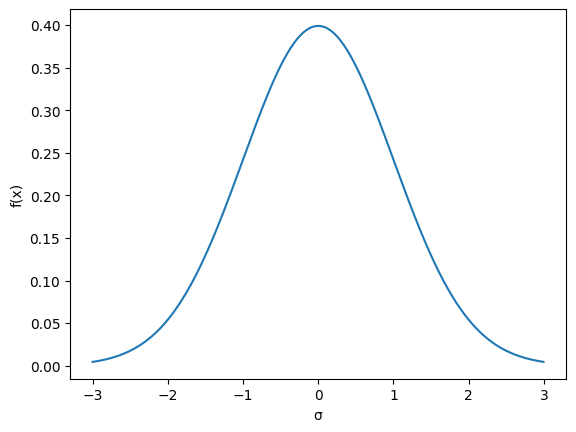

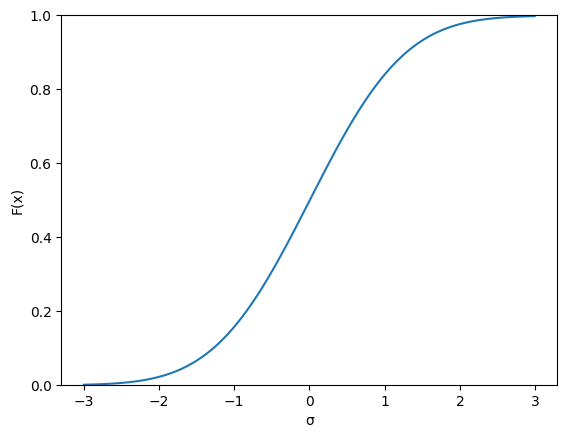

In [3]:
import numpy as np
dx = 0.005
x = np.arange(-3,3,dx)

mu    = 0
sigma = 1
fx = 1/((2*np.pi)**0.5*sigma)*np.exp(-(x-mu)**2/(2*sigma**2))
Fx = [np.sum(fx[:i]*dx) for i in range(len(fx))]
label = ("σ", "f(x)"); Label = ("σ", "F(x)")
show_plot(x,fx, label,0); show_plot(x,Fx, Label,1)

横軸であるσ軸は実際のデータと比例で対応している。  
加えて，σはF(x)と非線形ではあるが１：１で対応しているため，累積確率を，σに読み替えることで，線形のグラフが得られる。  
上記を実現するため，指定した確率に最も近いσの値を探索する処理を実装する。  
np.abs():入力した行列すべての要素を絶対値にする。
np.argmin():入力した行列の最小値の場所（インデックス）を取得する。

In [4]:
value = 0.98
index = np.argmin(np.abs(np.array(Fx) - value)) #検索値と誤差が最小になる場所を知る
print(f"index:{index}, serched value:{Fx[index]}, serched σ:{x[index]}")

index:1017, serched value:0.9800128414149516, serched σ:2.0849999999998916


これを全データに適用する。

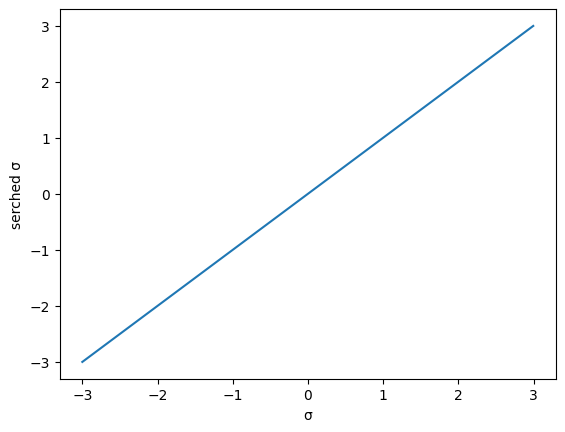

In [5]:
searched_sigma = [x[np.argmin(np.abs(np.array(Fx) - value))] for value in Fx]
label = ("σ", "serched σ"); show_plot(x,searched_sigma, label,0)

### 実験データへの適用
上記は，正規分布関数から得られた累積確率を検索値として使用したので当然直線だったが，これを実験データへ適用すると，直線に近い程正規分布に近いという判断が下せるようになる。  
まずは，製品Aに対して生起確率紙を描画する。

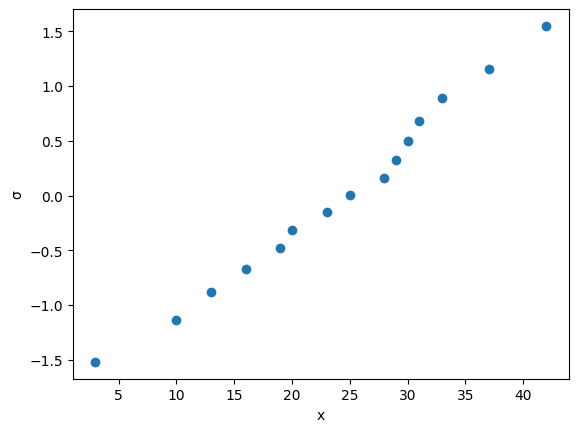

In [6]:
import pandas as pd
filepath = "./datas/1st_week_product_service_lifes.csv"
df = pd.read_csv(filepath)

data = np.array(df.iloc[:,[1]]).squeeze()
xx = data[~np.isnan(data)] #理論値のxを上書きしないように変数名を変えておく
yy = np.arange(1,len(xx)+1) / (len(xx)+1)
#ランク法で予測した累積確率yyに対応するσを検索
searched_sigma = [x[np.argmin(np.abs(np.array(Fx) - value))] for value in yy]
label = ("x", "σ"); show_scatter(xx, searched_sigma, label,0)

### らしさの数値化と母数の推定
プロットが得られれば，直線への近似は最小二乗法で決定的に行える。  
また，直線らしさの評価自体は，0で無相関，1で完全な直線となる相関係数，または決定係数を使用して行える。  
正規分布における母数である，標準偏差σと，平均値μの２つも確率紙を使用して特定可能である。  
  
numpy.polyfit():x,y,次元数を入力し，指定次数の関数近似結果を，係数a,b,c...の配列で返す。直線の場合は，係数は傾きaと切片bのみ  
numpy.corrcoef():x,yを入力し，直線近似に対する相関行列を返す。[0][1]または[1][0]成分が相関係数


In [7]:
a,b = np.polyfit(xx,searched_sigma,1)
r =   np.corrcoef(xx,searched_sigma)[0][1]

標準偏差σ   ：縦軸 1 の変化に相当する x の変化  
平均値μ     ：縦軸 0 に相当する x の値 

In [8]:
sigma = 1/a
mu = -b/a

結果の表示とグラフ化

(normal distribution) r: 0.9934402478682097, σ: 12.245845494928256, μ: 23.835366569374695


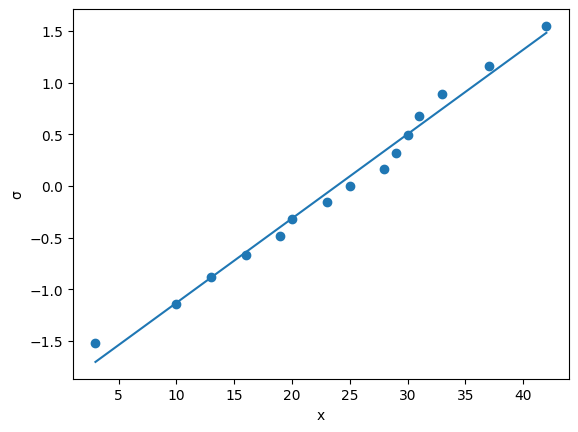

In [9]:
print(f"(normal distribution) r: {r}, σ: {sigma}, μ: {mu}")
plt.scatter(xx, searched_sigma)
fit = a*xx+b
plt.plot(xx,fit)
plt.xlabel("x"); plt.ylabel("σ")
plt.show()

## 対数正規分布に対する確立紙
対数正規分布は，確率変数の対数をとったとき，対応する分布が正規分布に従うものとして定義されているため，その確率紙は，横軸の変数xの自然対数とするのみでよい。

xxの自然対数を準備

In [10]:
lnxx = np.log(xx)

後は同様

(log-normal distribution) r: 0.8909690262815815, σ: 0.8566018711149616, μ: 3.020684303270089


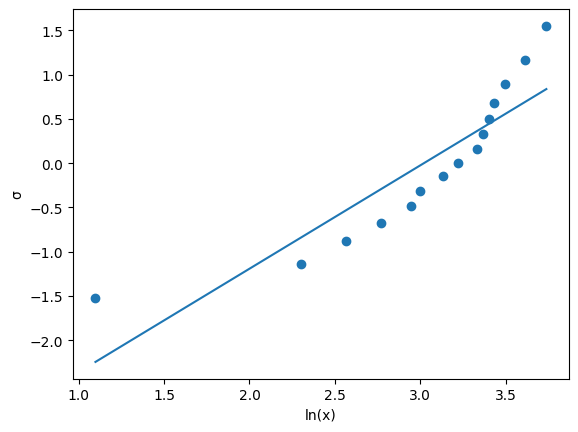

In [11]:
a,b = np.polyfit(lnxx,searched_sigma,1)
r =   np.corrcoef(lnxx,searched_sigma)[0][1]
sigma = 1/a; mu = -b/a
print(f"(log-normal distribution) r: {r}, σ: {sigma}, μ: {mu}")
plt.scatter(lnxx, searched_sigma)
fit = a*lnxx+b
plt.plot(lnxx,fit)
plt.xlabel("ln(x)"); plt.ylabel("σ")
plt.show()

## 2母数ワイブル確率紙
2母数ワイブル分布は累積分布関数が数学的に決定できるため，確率紙の縦軸も数学的に準備できる。

In [12]:
Y = np.log(np.log(1/(1-yy)))
X = np.log(xx)

(2-parameter Weibull distribution) r: 0.946425108095374, m: 1.5073572116357188, η: -5.076415724038767


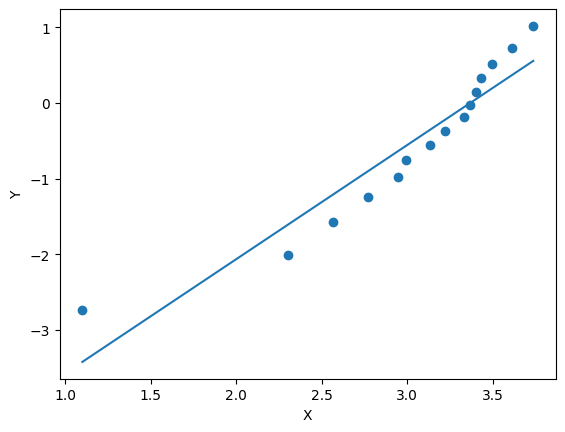

In [13]:
a,b = np.polyfit(X,Y,1)
r =   np.corrcoef(X,Y)[0][1]
m = a; eta = b
print(f"(2-parameter Weibull distribution) r: {r}, m: {m}, η: {eta}")
plt.scatter(X, Y)
fit = a*X+b
plt.plot(X,fit)
plt.xlabel("X"); plt.ylabel("Y")
plt.show()

## 3母数ワイブル分布（やらない？）
2母数ワイブル確率紙のXが，ln(x)からln(x-γ)となるため，確率紙を描画する前にγを定める必要がある。  
近代では３母数以上の近似も反復法で特に問題なく可能だが，確率紙の相関係数比較による分布関数選定は不可能である。  
ここでは，ワイブル自身の提案している。相関係数が最大，つまり確率紙が最も直線に近づく位置母数γを探索してから確率紙を記載する方法を実施する。

In [14]:
delta=1                                        #γのステップの初期値
gamma=0                                         #位置母数の初期値0
best_gamma = gamma
Y = np.log(np.log(1/(1-yy)))               
X = np.log(xx-gamma)                       
r = np.corrcoef(X,Y)[0][1]    #初期値に対するrを計算し，最大値として保管
rmax = r
rbuf = r
while True:
    gamma+=delta
    X = np.log(xx-gamma)                       
    r = np.corrcoef(X,Y)[0][1]
    print(f"{r}, {gamma}, {rmax}, {best_gamma}")

    if r > rmax and gamma>0: #最大値が得られれば記録
        rmax=r
        best_gamma = gamma
    elif r > rbuf:
        pass
    else:
        delta *= -0.1               #相関係数が現象に転じればステップを小さくしつつ反転
        if np.abs(delta) < 1e-6:    #deltaが十分に小さくなればループから抜ける
            break
    rbuf=r

0.9295389540898307, 1, 0.946425108095374, 0
0.9316432944842847, 0.9, 0.946425108095374, 0
0.9336340913049987, 0.8, 0.946425108095374, 0
0.9355209591895678, 0.7000000000000001, 0.946425108095374, 0
0.9373123728049126, 0.6000000000000001, 0.946425108095374, 0
0.9390158409090562, 0.5000000000000001, 0.946425108095374, 0
0.9406380481202672, 0.40000000000000013, 0.946425108095374, 0
0.9421849713828511, 0.30000000000000016, 0.946425108095374, 0
0.9436619764045175, 0.20000000000000015, 0.946425108095374, 0
0.9450738980924603, 0.10000000000000014, 0.946425108095374, 0
0.946425108095374, 1.3877787807814457e-16, 0.946425108095374, 0
0.9477195718724546, -0.09999999999999987, 0.946425108095374, 0
0.9489608971929228, -0.19999999999999987, 0.946425108095374, 0
0.9501523755754253, -0.2999999999999999, 0.946425108095374, 0
0.9512970178735041, -0.3999999999999999, 0.946425108095374, 0
0.9523975849781791, -0.4999999999999999, 0.946425108095374, 0
0.9534566144247361, -0.5999999999999999, 0.94642510809537

In [15]:
best_gamma

0

得られた位置母数 γ をもとに確率紙を作成。

(3-parameter Weibull distribution) r: 0.946425108095374, m: 1.5073572116357188, η: -5.076415724038767, γ: 0


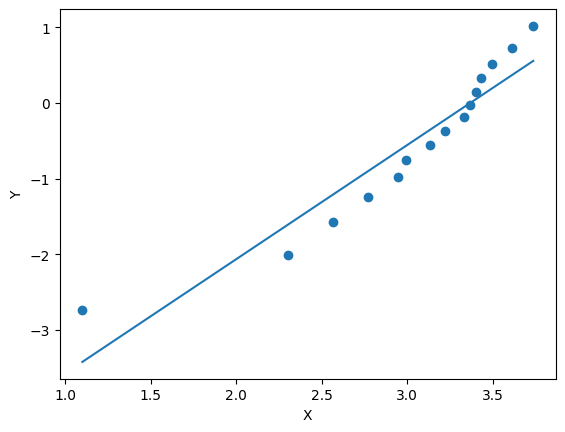

In [16]:
Y = np.log(np.log(1/(1-yy)))
X = np.log(xx-best_gamma)
m,eta = np.polyfit(X,Y,1)
r =   np.corrcoef(X,Y)[0][1]
print(f"(3-parameter Weibull distribution) r: {r}, m: {m}, η: {eta}, γ: {best_gamma}")
plt.scatter(X, Y)
fit = m*X+eta
plt.plot(X,fit)
plt.xlabel("X"); plt.ylabel("Y")
plt.show()

### 結果を並べて表示
ここまでに作成してきた４種類の確率紙をすべて並べて表示する。
plt.subplot()を使用すると，複数のグラフを１枚の図として表示できる。

(normal distribution) r: 0.9934402478682097, σ: 12.245845494928256, μ: 23.835366569374695
(log-normal distribution) r: 0.8909690262815815, σ: 0.8566018711149616, μ: 3.020684303270089
(2-parameter Weibull distribution) r: 0.946425108095374, m: 1.5073572116357188, η: -5.076415724038767
(3-parameter Weibull distribution) r: 0.946425108095374, m: 1.5073572116357188, η: -5.076415724038767, γ: 0


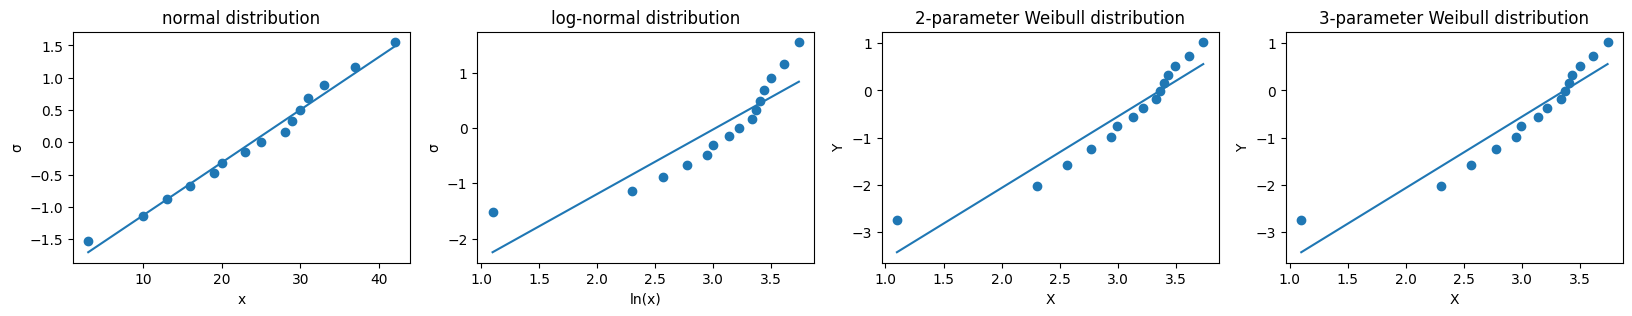

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dx = 0.005; x = np.arange(-3,3,dx)
mu    = 0; sigma = 1
fx = 1/((2*np.pi)**0.5*sigma)*np.exp(-(x-mu)**2/(2*sigma**2))
Fx = [np.sum(fx[:i]*dx) for i in range(len(fx))]

filepath = "./datas/1st_week_product_service_lifes.csv"
df = pd.read_csv(filepath)

data = np.array(df.iloc[:,[1]]).squeeze()
xx = data[~np.isnan(data)] #理論値のxを上書きしないように変数名を変えておく
yy = np.arange(1,len(xx)+1) / (len(xx)+1)
#ランク法で予測した累積確率yyに対応するσを検索
searched_sigma = [x[np.argmin(np.abs(np.array(Fx) - value))] for value in yy]

plt.figure(figsize=(20,3))
#正規確率紙
a,b = np.polyfit(xx,searched_sigma,1)
r =   np.corrcoef(xx,searched_sigma)[0][1]
sigma = 1/a; mu = -b/a
print(f"(normal distribution) r: {r}, σ: {sigma}, μ: {mu}")
plt.subplot(1,4,1)
plt.title("normal distribution")
plt.scatter(xx, searched_sigma)
fit = a*xx+b
plt.plot(xx,fit)
plt.xlabel("x"); plt.ylabel("σ")

#対数正規確率紙
lnxx = np.log(xx)
a,b = np.polyfit(lnxx,searched_sigma,1)
r =   np.corrcoef(lnxx,searched_sigma)[0][1]
sigma = 1/a; mu = -b/a
print(f"(log-normal distribution) r: {r}, σ: {sigma}, μ: {mu}")
plt.subplot(1,4,2)
plt.title("log-normal distribution")
plt.scatter(lnxx, searched_sigma)
fit = a*lnxx+b
plt.plot(lnxx,fit)
plt.xlabel("ln(x)"); plt.ylabel("σ")

#2母数ワイブル確率紙
Y = np.log(np.log(1/(1-yy)))
X = np.log(xx)
m,eta = np.polyfit(X,Y,1)
r =   np.corrcoef(X,Y)[0][1]
print(f"(2-parameter Weibull distribution) r: {r}, m: {m}, η: {eta}")
plt.subplot(1,4,3)
plt.title("2-parameter Weibull distribution")
plt.scatter(X, Y)
fit = m*X+eta
plt.plot(X,fit)
plt.xlabel("X"); plt.ylabel("Y")

#3母数ワイブル確率紙
delta=1; gamma=0
best_gamma = gamma
X = np.log(xx-gamma); Y = np.log(np.log(1/(1-yy)))                       
r = np.corrcoef(X,Y)[0][1]
rmax = r; rbuf = r
while True:
    gamma+=delta
    if gamma>0 and np.min(xx-gamma)>0:
        X = np.log(xx-gamma)                       
        r = np.corrcoef(X,Y)[0][1]
    if r > rmax and gamma>0:
        rmax=r
        best_gamma = gamma
    elif r > rbuf:
        pass
    else:
        delta *= -0.1 
        if np.abs(delta) < 1e-6:
            break
    rbuf=r

Y = np.log(np.log(1/(1-yy)))
X = np.log(xx-best_gamma)
m,eta = np.polyfit(X,Y,1)
r =   np.corrcoef(X,Y)[0][1]
print(f"(3-parameter Weibull distribution) r: {r}, m: {m}, η: {eta}, γ: {best_gamma}")
plt.subplot(1,4,4)
plt.title("3-parameter Weibull distribution")
plt.scatter(X, Y)
fit = m*X+eta
plt.plot(X,fit)
plt.xlabel("X"); plt.ylabel("Y")
plt.show()

この処理を製品に対してループすれば，５製品すべての，４種類の確率紙は一気に確認できる。

productA
(normal distribution) r: 0.9934402478682097, σ: 12.245845494928256, μ: 23.835366569374695
(log-normal distribution) r: 0.8909690262815815, σ: 0.8566018711149616, μ: 3.020684303270089
(2-parameter Weibull distribution) r: 0.946425108095374, m: 1.5073572116357188, η: -5.076415724038767
(3-parameter Weibull distribution) r: 0.946425108095374, m: 1.5073572116357188, η: -5.076415724038767, γ: 0


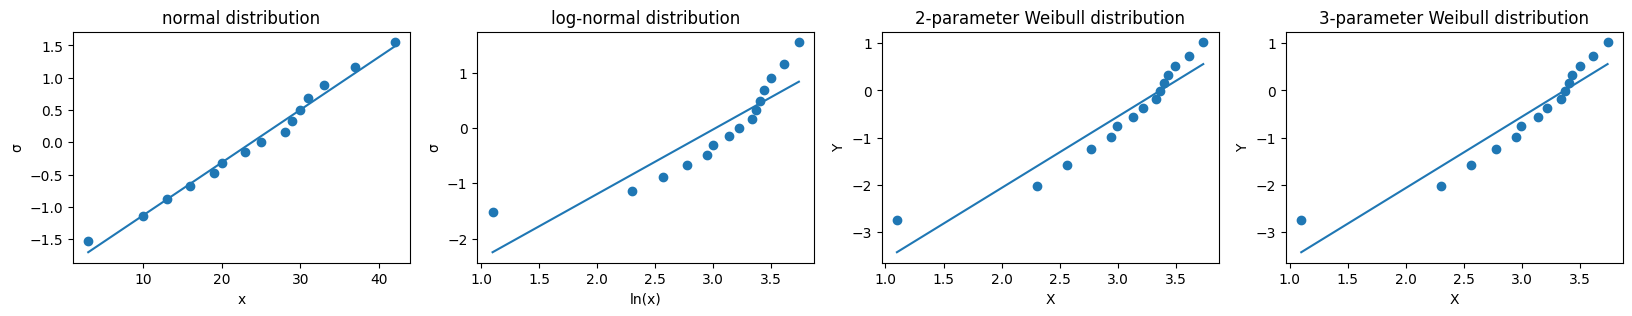

productB
(normal distribution) r: 0.9130429415022907, σ: 22.940372635997132, μ: 20.54981035224683
(log-normal distribution) r: 0.9992812814682718, σ: 1.008748081797237, μ: 2.682323852065153
(2-parameter Weibull distribution) r: 0.9873147512461747, m: 1.1905748563242728, η: -3.7159510709744437
(3-parameter Weibull distribution) r: 0.9968173453306493, m: 0.9529070483087861, η: -2.854887861179232, γ: 1.9411450000001047


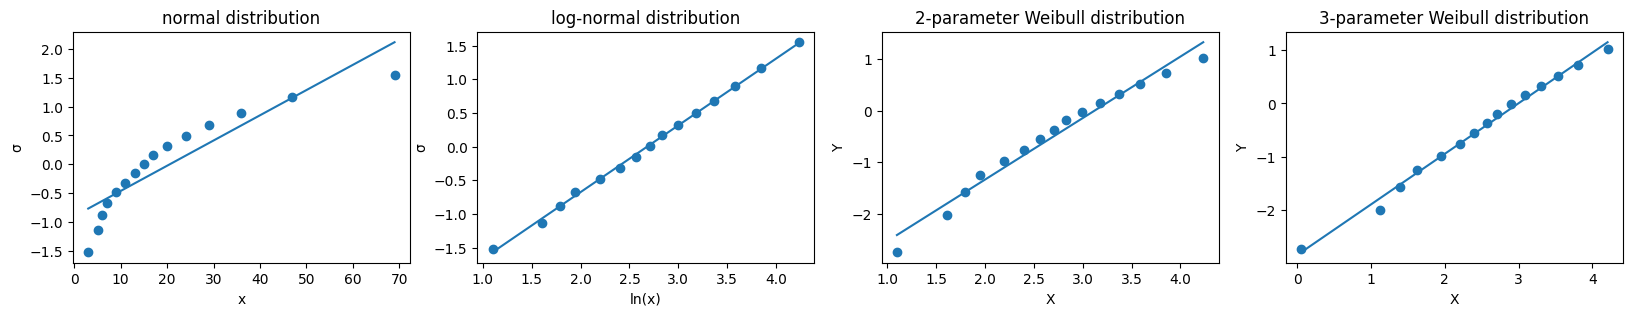

productC
(normal distribution) r: 0.9687244115894514, σ: 36.94787130125767, μ: 36.059838836544195
(log-normal distribution) r: 0.9629768647766065, σ: 1.4884859322283999, μ: 3.1219086677240266
(2-parameter Weibull distribution) r: 0.9909695475927203, m: 0.8327752153106299, η: -3.1031119486195293
(3-parameter Weibull distribution) r: 0.9909695475927203, m: 0.8327752153106299, η: -3.1031119486195293, γ: 0


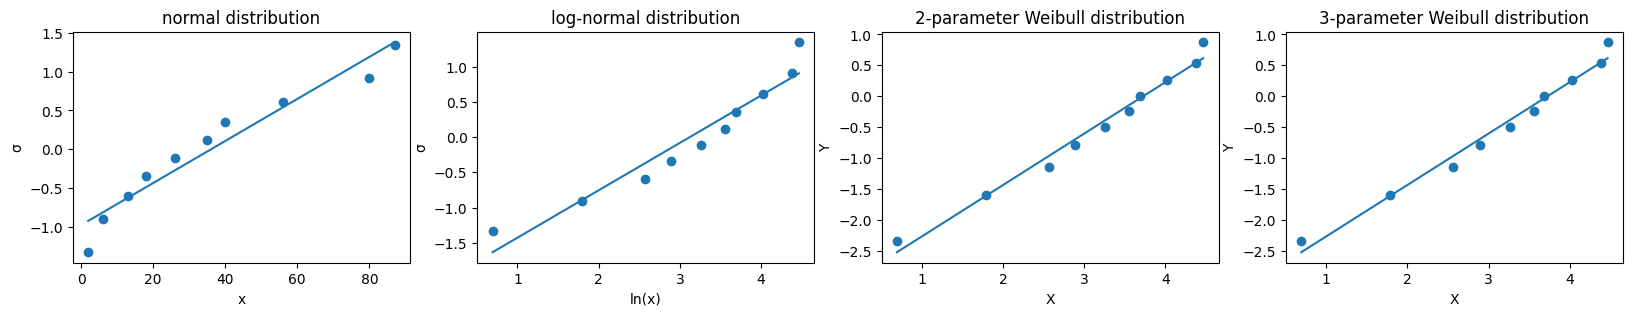

productD
(normal distribution) r: 0.9687244115894514, σ: 36.94787130125767, μ: 157.0598388365443
(log-normal distribution) r: 0.9815291631671613, σ: 0.22464824010383183, μ: 5.041276871865298
(2-parameter Weibull distribution) r: 0.9506542440263764, m: 5.1933122234584275, η: -26.683714698852825
(3-parameter Weibull distribution) r: 0.996974443104276, m: 1.065635439006605, η: -4.061562590064626, γ: 117.85042600000006


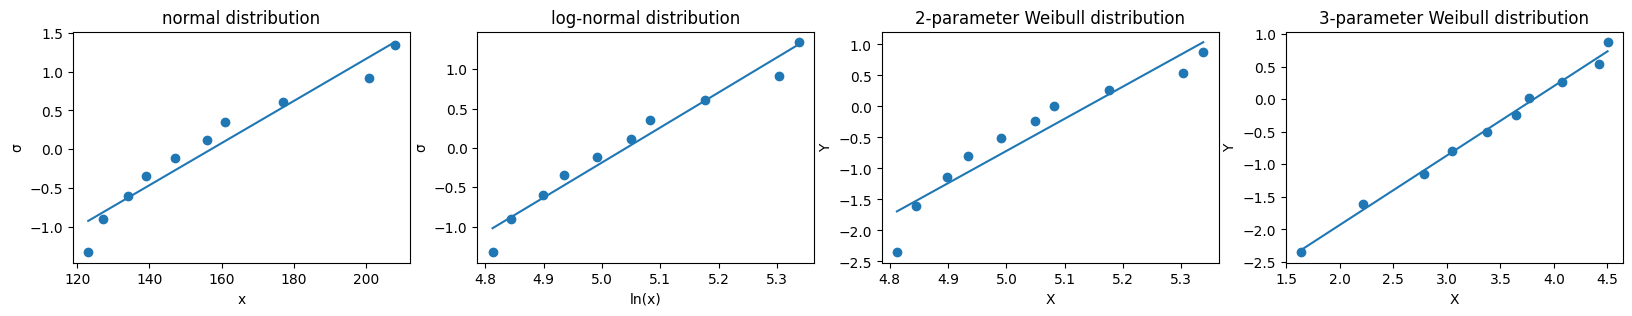

productE
(normal distribution) r: 0.9951761453820499, σ: 12.794512376976119, μ: 19.393379063526023
(log-normal distribution) r: 0.952531863708443, σ: 0.9340694090149956, μ: 2.7564295848982012
(2-parameter Weibull distribution) r: 0.9879041303020509, m: 1.3423132072476187, η: -4.213938478932677
(3-parameter Weibull distribution) r: 0.9879041303020509, m: 1.3423132072476187, η: -4.213938478932677, γ: 0


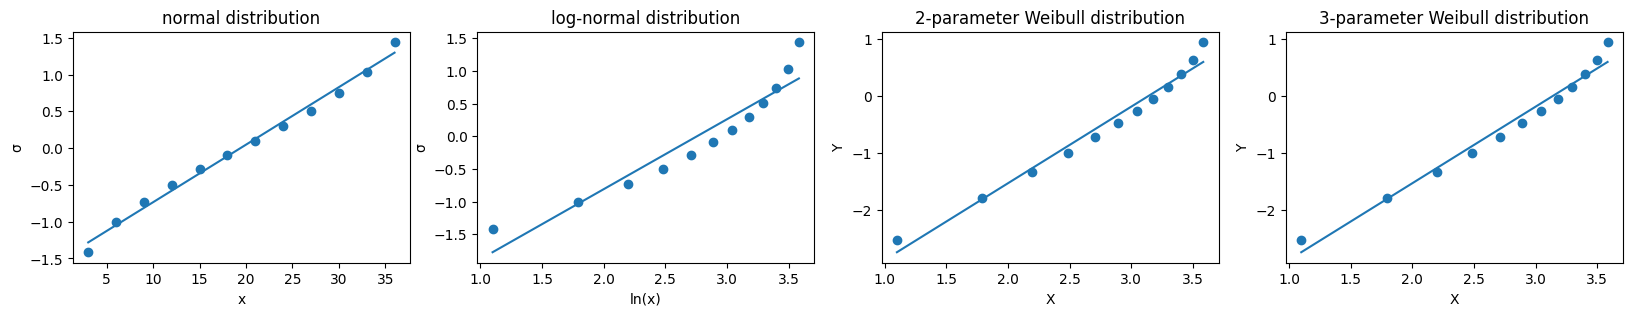

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dx = 0.005; x = np.arange(-3,3,dx)
mu    = 0; sigma = 1
fx = 1/((2*np.pi)**0.5*sigma)*np.exp(-(x-mu)**2/(2*sigma**2))
Fx = [np.sum(fx[:i]*dx) for i in range(len(fx))]

filepath = "./datas/1st_week_product_service_lifes.csv"
df = pd.read_csv(filepath)


for i in range(1,6):
    print(df.columns[i])
    data = np.array(df.iloc[:,[i]]).squeeze()
    xx = data[~np.isnan(data)] #理論値のxを上書きしないように変数名を変えておく
    yy = np.arange(1,len(xx)+1) / (len(xx)+1)
    #ランク法で予測した累積確率yyに対応するσを検索
    searched_sigma = [x[np.argmin(np.abs(np.array(Fx) - value))] for value in yy]

    plt.figure(figsize=(20,3))
    #正規確率紙
    a,b = np.polyfit(xx,searched_sigma,1)
    r =   np.corrcoef(xx,searched_sigma)[0][1]
    sigma = 1/a; mu = -b/a
    print(f"(normal distribution) r: {r}, σ: {sigma}, μ: {mu}")
    plt.subplot(1,4,1)
    plt.title("normal distribution")
    plt.scatter(xx, searched_sigma)
    fit = a*xx+b
    plt.plot(xx,fit)
    plt.xlabel("x"); plt.ylabel("σ")

    #対数正規確率紙
    lnxx = np.log(xx)
    a,b = np.polyfit(lnxx,searched_sigma,1)
    r =   np.corrcoef(lnxx,searched_sigma)[0][1]
    sigma = 1/a; mu = -b/a
    print(f"(log-normal distribution) r: {r}, σ: {sigma}, μ: {mu}")
    plt.subplot(1,4,2)
    plt.title("log-normal distribution")
    plt.scatter(lnxx, searched_sigma)
    fit = a*lnxx+b
    plt.plot(lnxx,fit)
    plt.xlabel("ln(x)"); plt.ylabel("σ")

    #2母数ワイブル確率紙
    Y = np.log(np.log(1/(1-yy)))
    X = np.log(xx)
    m,eta = np.polyfit(X,Y,1)
    r =   np.corrcoef(X,Y)[0][1]
    print(f"(2-parameter Weibull distribution) r: {r}, m: {m}, η: {eta}")
    plt.subplot(1,4,3)
    plt.title("2-parameter Weibull distribution")
    plt.scatter(X, Y)
    fit = m*X+eta
    plt.plot(X,fit)
    plt.xlabel("X"); plt.ylabel("Y")

    #3母数ワイブル確率紙
    delta=1; gamma=0
    best_gamma = gamma
    X = np.log(xx-gamma); Y = np.log(np.log(1/(1-yy)))                       
    r = np.corrcoef(X,Y)[0][1]
    rmax = r; rbuf = r
    while True:
        gamma+=delta
        if gamma>0 and np.min(xx-gamma)>0:
            X = np.log(xx-gamma)                       
            r = np.corrcoef(X,Y)[0][1]
        if r > rmax and gamma>0:
            rmax=r
            best_gamma = gamma
        elif r > rbuf:
            pass
        else:
            delta *= -0.1 
            if np.abs(delta) < 1e-6:
                break
        rbuf=r

    Y = np.log(np.log(1/(1-yy)))
    X = np.log(xx-best_gamma)
    m,eta = np.polyfit(X,Y,1)
    r =   np.corrcoef(X,Y)[0][1]
    print(f"(3-parameter Weibull distribution) r: {r}, m: {m}, η: {eta}, γ: {best_gamma}")
    plt.subplot(1,4,4)
    plt.title("3-parameter Weibull distribution")
    plt.scatter(X, Y)
    fit = m*X+eta
    plt.plot(X,fit)
    plt.xlabel("X"); plt.ylabel("Y")
    plt.show()

# レポート課題2
1. 上記確率紙を，課題１で指定されたランク法で予測した累積確率に基づいて作成し，最も適当な分布関数を決定する。
1. 決定した分布関数に近似した際の母数を使用して，確率密度分布を作図する。
1. 同じく，累積確率分布を作図する。

# レポート課題3
1. 論文「A　Study　on　･･･････････…」について，400字程度の和文概要を作成する。
1. 同論文の作成に使用された元データに基づき，Fig. 1 から 4 を再現せよ。

1. 論文「Relationship ････････…」ついて，400字程度の和文概要を作成する。
1. 同論文の作成に使用された元データに基づき，Fig. 3 を再現せよ。

※論文においては確率紙の縦軸を，対応する確率で記載しているが，レポートにおいては，σまたはYで作成する。

未入力データ
1-fig2のデータ
kb1.5, 2.5,3.8